In [1]:
!pip install tensorflow matplotlib opencv-python

In [3]:
import cv2
import os
import random
import matplotlib.pyplot as plt
import numpy as np

In [7]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Dense, Conv2D, MaxPooling2D, Flatten, Input

In [9]:
#ASSIGNING STORAGE PATH

POS_PATH = os.path.join('database', 'positive')
NEG_PATH = os.path.join('database', 'negative')
ANC_PATH = os.path.join('database', 'anchor')

In [11]:
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

In [13]:
#IMPORTING UNIVERSALLY UNIQUE IDENTIFIER

import uuid
uuid.uuid1() 

UUID('75082c60-23d0-11ef-8c18-84a93e422fae')

In [15]:
#ACCESSING MY SYSTEM'S WEBCAM

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    
#CAPTURING IMAGES AND STORING IN THE ANCHOR DIRECTORY    
    
    if cv2.waitKey(1) & 0XFF == ord('a'):
            imagename = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
            cv2.imwrite(imagename, frame)

#CAPTURING IMAGES AND STORING IN THE POSITIVE DIRECTORY

    if cv2.waitKey(1) & 0XFF == ord('p'):
            imagename = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
            cv2.imwrite(imagename, frame)
    
    cv2.imshow('Image Collection', frame)

#CLOSING THE WEBCAM

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

In [17]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(250)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(250)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(250)

In [19]:
#CREATING A PREPROCESS FUNCTION
#THIS FUNCTION RESIZES THE IMAGE

def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

In [21]:
#CONCATENATING THE POSITIVE AND NEGATIVE DIRECTORIES TO ONE DATASET FOR TRAINING

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
data = positives.concatenate(negatives)

In [23]:
#CREATING ANOTHER PREPROCESSING FUNCTION

def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [25]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [27]:
#ASSIGNING 70% OF THE ENTIRE DATASET FOR TRAINING
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [29]:
#ASSIGNING 30% OF THE ENTIRE DATASET FOR TESTING THE MODEL
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [31]:
#CREATING THE EMBEDDED LAYER OF THE MODEL

def make_embedding():
    inp = Input(shape = (100, 100, 3), name = 'input_image')
    
    c1 = Conv2D(64,(10, 10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64,(2,2), padding = 'same')(c1)
    
    c2 = Conv2D(128,(7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding = 'same')(c2)
    
    c3 = Conv2D(128,(4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding = 'same')(c3)
    
    c4 = Conv2D(256,(4,4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1] ,name= 'embedding')

In [33]:
#CHECKING TO SEE IF THE EMBEDDED LAYER HAS BEEN SUCESSFULLY CREATED

embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
#CREATING MY L1DIST LAYER

class L1Dist(Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [37]:
#CREATING MY INPUT IMAGE VARIABLE
input_image = Input(name = 'input_img', shape = (100, 100, 3))
embedding(input_image)

[<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_9>]

In [39]:
#CREATING MY VALIDATION IMAGE VARIABLE
validation_image = Input(name = 'validation_img', shape = (100, 100, 3))
embedding(validation_image)

[<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_10>]

In [47]:
from tensorflow.keras.applications import MobileNetV2


# Example embedding model
def get_embedding_model():
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, pooling='avg')
    return Model(inputs=base_model.input, outputs=base_model.output)

# Example input images (assuming they are preprocessed appropriately)
input_image = tf.random.normal([1, 224, 224, 3])  # Example input image tensor
validation_image = tf.random.normal([1, 224, 224, 3])  # Example validation image tensor

# Instantiate the embedding model
embedding_model = get_embedding_model()

# Get embeddings for both images
input_embedding = embedding_model(input_image)
validation_embedding = embedding_model(validation_image)

# Check the types of embeddings to ensure they are tensors
print(f"Type of input_embedding: {type(input_embedding)}")
print(f"Type of validation_embedding: {type(validation_embedding)}")

# Instantiate the custom layer
siamese_layer = L1Dist()

# Compute the L1 distance between the embeddings
distance = siamese_layer(input_embedding, validation_embedding)

print("L1 Distance:", distance.numpy())


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 63s 7us/step
Type of input_embedding: <class 'tensorflow.python.framework.ops.EagerTensor'>
Type of validation_embedding: <class 'tensorflow.python.framework.ops.EagerTensor'>
L1 Distance: [[0.02773748 0.08391392 0.         ... 0.         0.12534916 0.3211575 ]]


In [53]:
def make_siamese_model():
    embedding_model = get_embedding_model()

    # Define input layers
    input_image = Input(name='input_image', shape=(224, 224, 3))
    validation_image = Input(name='validation_image', shape=(224, 224, 3))

    # Get embeddings
    input_embedding = embedding_model(input_image)
    validation_embedding = embedding_model(validation_image)

    # Compute the L1 distance between the embeddings
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(input_embedding, validation_embedding)

    # Add a classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    # Create the Siamese network model
    siamese_model = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

    return siamese_model


In [55]:
# Build the Siamese network
siamese_network = make_siamese_model()

# Display the model summary
siamese_network.summary()


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 1280)      │  2,257,984 │ input_image[0][0… │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_4 (L1Dist)  │ (None, 1280)      │          0 │ functional_3[0][… │
│                     │                   │            │ functional_3[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      1,281 │ l1_dist_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 2,225,153 (8.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [57]:
#ASSIGNING MY BINARY LOSS 

binary_cross_loss = tf.losses.BinaryCrossentropy()

#ASSIGNING MY OPTIMIZER

opt = tf.keras.optimizers.Adam(1e-4)

In [59]:
siamese_model = make_siamese_model()
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [61]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        x = batch[:2]
        y = batch[2]
        
        y_pred = siamese_model(x, training = True)
        loss = binary_cross_loss(y, y_pred)
    print(loss)
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
        
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    return loss

In [63]:
#CREATING MY TRAIN FUNCTION

def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch{}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
            
            if epoch % 10 == 0:
                checkpoint.save(file_prefix=checkpoint_prefix)

In [67]:
import tensorflow as tf

def preprocess_image(image):
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0  # Normalize the image
    return image

def preprocess(data):
    # Assuming `data` is a batch of images with shape (batch_size, height, width, channels)
    return tf.map_fn(preprocess_image, data)


In [69]:
# Example preprocessing of a single batch of images
batch_size = 16
input_image = tf.random.normal([batch_size, 100, 100, 3])  # Example input image tensor
validation_image = tf.random.normal([batch_size, 100, 100, 3])  # Example validation image tensor

input_image = preprocess(input_image)
validation_image = preprocess(validation_image)


In [81]:
def train_step(batch):
    x, y = batch[:2], batch[2]
    x = (preprocess(x[0]), preprocess(x[1]))
    with tf.GradientTape() as tape:
        y_pred = siamese_model(x, training=True)
        loss = binary_cross_loss(y, y_pred)
    gradients = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(gradients, siamese_model.trainable_variables))
    return loss

def train(data, epochs):
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        progbar = tf.keras.utils.Progbar(len(data))
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            progbar.update(idx+1)
            if epoch % 10 == 0:
                print(f'Loss at epoch {epoch}: {loss.numpy()}')


In [77]:
# Example of creating a dataset with the correct preprocessing
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = preprocess_image(image)
    return image


#CONCATENATING THE POSITIVE AND NEGATIVE DIRECTORIES TO ONE DATASET FOR TRAINING

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
data = positives.concatenate(negatives)

In [83]:
#ASSIGNING EPOCH VALUE

EPOCHS = 20

#TRAINING THE MODEL

train(train_data, EPOCHS)

Epoch 1/20
 1/22 ━━━━━━━━━━━━━━━━━━━━ 6:30 19s/stepLoss at epoch 0: 1.0043836832046509
 2/22 ━━━━━━━━━━━━━━━━━━━━ 4:18 13s/stepLoss at epoch 0: 0.8455885052680969
 3/22 ━━━━━━━━━━━━━━━━━━━━ 3:58 13s/stepLoss at epoch 0: 0.8010265827178955
 4/22 ━━━━━━━━━━━━━━━━━━━━ 3:41 12s/stepLoss at epoch 0: 0.6563393473625183
 5/22 ━━━━━━━━━━━━━━━━━━━━ 3:23 12s/stepLoss at epoch 0: 0.648815929889679
 6/22 ━━━━━━━━━━━━━━━━━━━━ 3:07 12s/stepLoss at epoch 0: 0.5248163938522339
 7/22 ━━━━━━━━━━━━━━━━━━━━ 2:54 12s/stepLoss at epoch 0: 0.31453120708465576
 8/22 ━━━━━━━━━━━━━━━━━━━━ 2:41 12s/stepLoss at epoch 0: 0.3030189871788025
 9/22 ━━━━━━━━━━━━━━━━━━━━ 2:29 12s/stepLoss at epoch 0: 0.2005859911441803
10/22 ━━━━━━━━━━━━━━━━━━━━ 2:18 12s/stepLoss at epoch 0: 0.1538589894771576
11/22 ━━━━━━━━━━━━━━━━━━━━ 2:06 12s/stepLoss at epoch 0: 0.18494045734405518
12/22 ━━━━━━━━━━━━━━━━━━━━ 1:54 11s/stepLoss at epoch 0: 0.10573782026767731
13/22 ━━━━━━━━━━━━━━━━━━━━ 1:43 11s/stepLoss at epoch 0: 0.0775613486766815

In [85]:
#IMPORTING THE ACCURACY METRICS

from tensorflow.keras.metrics import Precision, Recall

In [87]:
#TESTING THE INPUT AND VALIDATION IMAGES

test_input, test_val, y_true = test_data.as_numpy_iterator().next()
test_input

array([[[[0.74607843, 0.7002451 , 0.71887255],
         [0.74313724, 0.7112745 , 0.69534314],
         [0.72745097, 0.7       , 0.6666667 ],
         ...,
         [0.76348037, 0.7823529 , 0.7590686 ],
         [0.76348037, 0.7801471 , 0.76348037],
         [0.75441176, 0.7627451 , 0.7632353 ]],

        [[0.7370098 , 0.70098037, 0.70490193],
         [0.73995095, 0.72132355, 0.69485295],
         [0.73137254, 0.7169118 , 0.67941177],
         ...,
         [0.74264705, 0.78112745, 0.7490196 ],
         [0.75759804, 0.7872549 , 0.75735295],
         [0.75490195, 0.777451  , 0.7632353 ]],

        [[0.73382354, 0.70098037, 0.6901961 ],
         [0.72156864, 0.7078431 , 0.6696078 ],
         [0.7176471 , 0.70686275, 0.66862744],
         ...,
         [0.7534314 , 0.77156866, 0.7561275 ],
         [0.75661767, 0.76740193, 0.74583334],
         [0.7794118 , 0.78137255, 0.77254903]],

        ...,

        [[0.6227941 , 0.5857843 , 0.5262255 ],
         [0.6259804 , 0.59362745, 0.55441177]

In [89]:
test_val

array([[[[7.35784292e-01, 7.24019587e-01, 6.98529422e-01],
         [7.44607866e-01, 7.21813738e-01, 7.09558845e-01],
         [7.34068632e-01, 6.99509799e-01, 7.01225519e-01],
         ...,
         [7.04411745e-01, 7.37990201e-01, 7.50980377e-01],
         [7.27450967e-01, 7.86029398e-01, 7.78676450e-01],
         [7.41176486e-01, 7.94117630e-01, 7.68137276e-01]],

        [[7.41666675e-01, 7.35784292e-01, 6.85784340e-01],
         [7.39705861e-01, 7.21078455e-01, 6.88725471e-01],
         [7.36029387e-01, 7.04166651e-01, 6.90196097e-01],
         ...,
         [7.12745070e-01, 7.34558821e-01, 7.48529434e-01],
         [7.04166651e-01, 7.36519635e-01, 7.27696061e-01],
         [7.40931392e-01, 7.60539234e-01, 7.45833337e-01]],

        [[7.28431344e-01, 7.25490212e-01, 7.03921556e-01],
         [7.35294104e-01, 7.21568644e-01, 7.00980365e-01],
         [7.39950955e-01, 7.05147088e-01, 6.88970566e-01],
         ...,
         [7.09313750e-01, 7.26715684e-01, 7.42156863e-01],
         [

In [91]:
y_true

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [95]:
def preprocess_image(image):
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0  # Normalize the image
    return image

def preprocess(data):
    return tf.map_fn(preprocess_image, data)


In [97]:
# Example test inputs
test_input = tf.random.normal([16, 100, 100, 3])  # Example test input tensor
test_val = tf.random.normal([16, 100, 100, 3])    # Example test validation tensor

# Preprocess the test inputs
test_input = preprocess(test_input)
test_val = preprocess(test_val)

# Make predictions
y_pred = siamese_model.predict([test_input, test_val])
print(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
[[0.5999269 ]
 [0.7143078 ]
 [0.6648888 ]
 [0.72551376]
 [0.71978664]
 [0.73946726]
 [0.76593405]
 [0.7102611 ]
 [0.76496094]
 [0.7742111 ]
 [0.6389396 ]
 [0.6443887 ]
 [0.65485924]
 [0.64656   ]
 [0.71276426]
 [0.62895167]]


In [99]:
[1 if prediction > 0.7 else 0 for prediction in y_pred]

[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0]

In [101]:
#TESTING THE RECALL METRICS

m = Recall()
m.update_state(y_true, y_pred)
m.result().numpy()

1.0

In [113]:
def preprocess_image(image):
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0  # Normalize the image to [0, 1] range
    return image

# Apply the preprocessing function
test_input = preprocess_image(test_input)
test_val = preprocess_image(test_val)


In [115]:
print(test_input[0].numpy().min(), test_input[0].numpy().max())
print(test_val[0].numpy().min(), test_val[0].numpy().max())


-5.242055e-05 5.597681e-05
-5.2632557e-05 4.982938e-05


0.059752252 0.8394065
0.0 0.981293


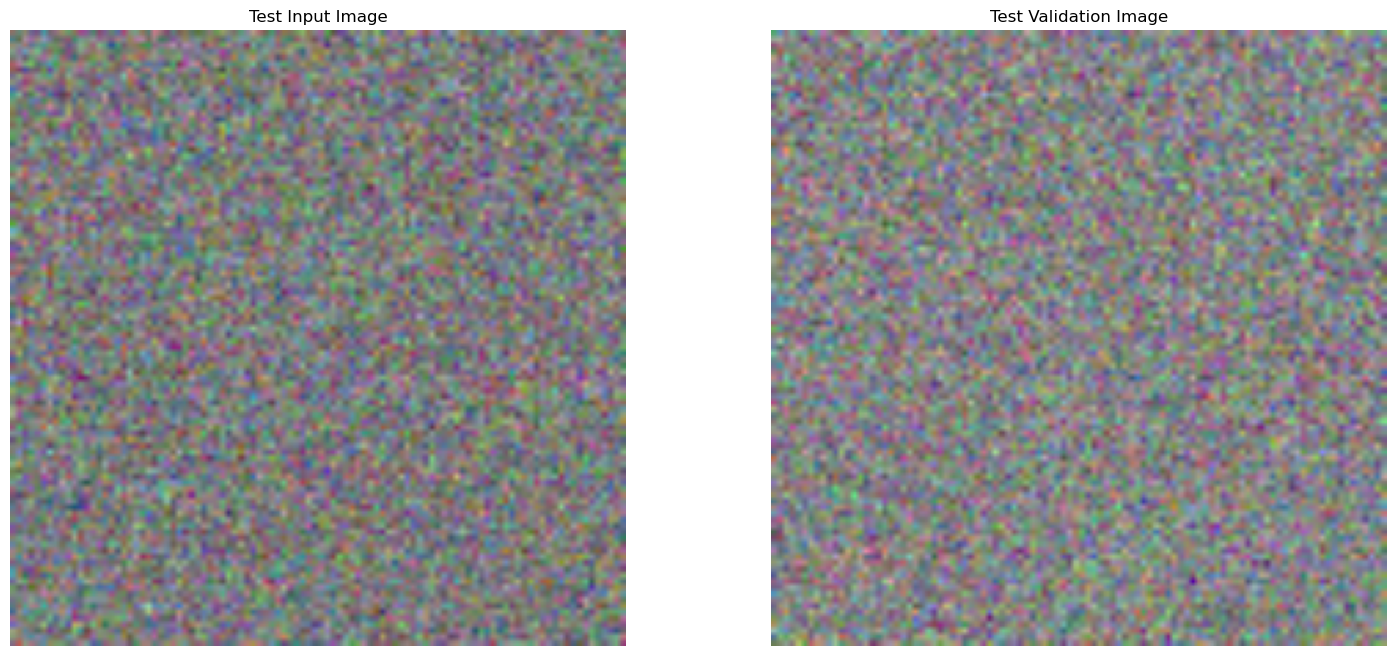

In [117]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the preprocess function using min-max scaling
def preprocess_image(image):
    image = tf.image.resize(image, (224, 224))
    min_val = tf.reduce_min(image)
    max_val = tf.reduce_max(image)
    image = (image - min_val) / (max_val - min_val)  # Normalize to [0, 1] range
    return image

# Generate example test data
test_input = tf.random.normal([16, 100, 100, 3])  # Example test input tensor
test_val = tf.random.normal([16, 100, 100, 3])    # Example test validation tensor

# Apply preprocessing
test_input = preprocess_image(test_input)
test_val = preprocess_image(test_val)

# Verify the new value ranges
print(test_input[0].numpy().min(), test_input[0].numpy().max())
print(test_val[0].numpy().min(), test_val[0].numpy().max())

# Display the images side by side
plt.figure(figsize=(18, 8))

# Display the first image
plt.subplot(1, 2, 1)
plt.imshow(test_input[0].numpy())
plt.title("Test Input Image")
plt.axis('off')

# Display the second image
plt.subplot(1, 2, 2)
plt.imshow(test_val[0].numpy())
plt.title("Test Validation Image")
plt.axis('off')

# Show the images
plt.show()


0.0 1.0
0.0 1.0


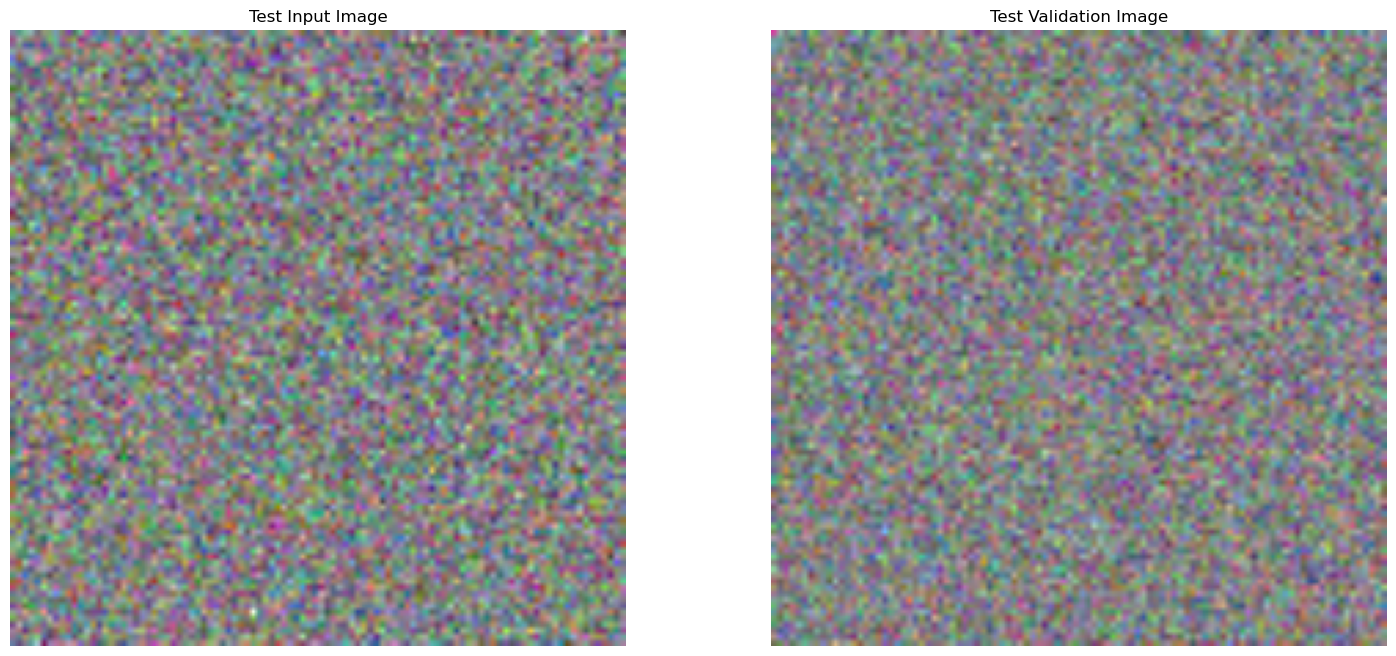

In [119]:
import tensorflow as tf
import matplotlib.pyplot as plt

def preprocess_image(image):
    # Resize the image to maintain aspect ratio
    image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
    min_val = tf.reduce_min(image)
    max_val = tf.reduce_max(image)
    image = (image - min_val) / (max_val - min_val)  # Normalize to [0, 1] range
    return image

# Generate example test data
test_input = tf.random.normal([16, 100, 100, 3])  # Example test input tensor
test_val = tf.random.normal([16, 100, 100, 3])    # Example test validation tensor

# Apply preprocessing
test_input = tf.map_fn(preprocess_image, test_input, dtype=tf.float32)
test_val = tf.map_fn(preprocess_image, test_val, dtype=tf.float32)

# Verify the new value ranges
print(test_input[0].numpy().min(), test_input[0].numpy().max())
print(test_val[0].numpy().min(), test_val[0].numpy().max())

# Display the images side by side
plt.figure(figsize=(18, 8))

# Display the first image
plt.subplot(1, 2, 1)
plt.imshow(test_input[0].numpy())
plt.title("Test Input Image")
plt.axis('off')

# Display the second image
plt.subplot(1, 2, 2)
plt.imshow(test_val[0].numpy())
plt.title("Test Validation Image")
plt.axis('off')

# Show the images
plt.show()


In [121]:
#SAVING THE MODEL

siamese_model.save('siamesemodel5.h5')

In [123]:
#COMPILING THE MODEL

model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

TypeError: Exception encountered when calling L1Dist.call().

[1mExpected float32 passed to parameter 'y' of op 'Sub', got ['embedding', 2, 0] of type 'list' instead. Error: Expected float32, but got embedding of type 'str'.[0m

Arguments received by L1Dist.call():
  • args=('<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_500>',)
  • kwargs={'validation_embedding': ["'embedding'", '2', '0']}